<a href="https://colab.research.google.com/github/kk20krishna/Custom-Medical-NER/blob/main/Krishna_Kumar_S_Syntactic_Processing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [ ]:
!pip install pycrf
!pip install sklearn-crfsuite
!pip install eli5

In [ ]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from spacy.matcher import Matcher
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import eli5
from spacy.tokenizer import Tokenizer

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

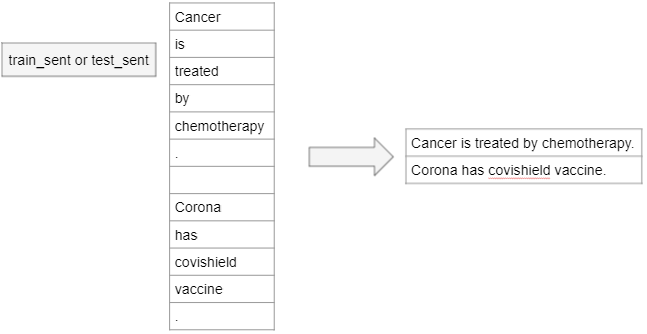

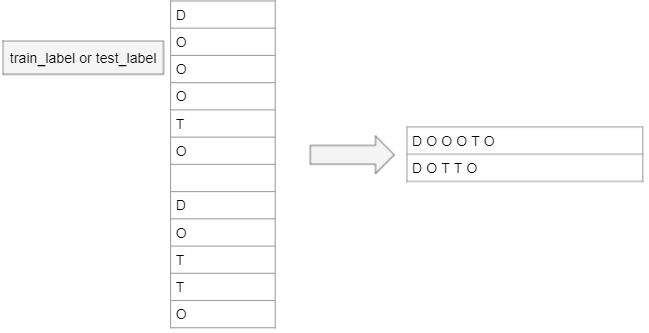

In [ ]:
def file_to_list(file_path):
    """
    Reads a text file and returns a list of sentences.

    Each sentence in the list is formed by concatenating consecutive non-empty lines,
    with empty lines serving as sentence separators.

    Args:
        file_path (str): The path to the text file.

    Returns:
        list: A list of strings.
              Returns an empty list if the file is not found.
    """
    file_list = []
    sentence = ''
    try:
        with open(file_path, 'r') as file:
            for line in file:
                if len(line.strip()) == 0:
                    file_list.append(sentence)
                    sentence = ''
                else:
                    if sentence == '':
                        sentence = line.strip()
                    else:
                        sentence = sentence + ' ' + line.strip()

        return file_list
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return []

In [ ]:
train_sent = file_to_list("train_sent")
train_label = file_to_list("train_label")

test_sent = file_to_list("test_sent")
test_label = file_to_list("test_label")

### Count the number of sentences in the processed train and test dataset

In [ ]:
print(f"Number of sentences in train dataset: {len(train_sent)}")
print(f"Number of sentences in test dataset: {len(test_sent)}")

Number of sentences in train dataset: 2599
Number of sentences in test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [ ]:
print(f"Number of lines in train label: {len(train_label)}")
print(f"Number of lines in test label: {len(test_label)}")

Number of lines in train label: 2599
Number of lines in test label: 1056


### Print sentence and labels

In [ ]:
train_sent[:1]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )']

In [ ]:
train_label[:1]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O']

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [ ]:
# Load the small English model from spaCy
nlp = spacy.load("en_core_web_sm")

# Disable Named Entity Recognition (NER) to speed up processing
nlp.disable_pipes("ner")

# Create a Matcher object using the shared vocabulary
matcher = Matcher(nlp.vocab)

# Define a pattern to match single tokens that are either NOUN or PROPER NOUN (PROPN)
pattern = [{"POS": {"IN": ["NOUN", "PROPN"]}}]

# Add the pattern to the matcher with a custom ID
matcher.add("NounOrPropNoun", [pattern])

# Initialize an empty dictionary to store matched nouns and their frequencies
noun_dict = {}

# Iterate over each sentence from training and test data
for sentence in train_sent + test_sent:
    # Process the sentence using the spaCy NLP pipeline
    doc = nlp(sentence)

    # Apply the matcher to find matches in the sentence
    matches = matcher(doc)

    # Loop over the matches found
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # Get the string ID of the match rule
        span = doc[start:end]  # Extract the matched span of text

        # Update the noun dictionary with the matched noun/proper noun
        if span.text not in noun_dict:
            noun_dict[span.text] = 1
        else:
            noun_dict[span.text] += 1

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [ ]:
noun_df = pd.DataFrame(list(noun_dict.items()), columns=['Noun', 'Count'])
noun_df = noun_df.sort_values(by='Count', ascending=False)
print("Top 25 most common tokens with NOUN or PROPN PoS tags")
noun_df.head(25)

Top 25 most common tokens with NOUN or PROPN PoS tags


,Noun,Count
18,patients,492
64,treatment,281
15,%,247
286,cancer,200
444,therapy,175
55,study,153
218,disease,141
1213,cell,140
1908,lung,116
11,group,94


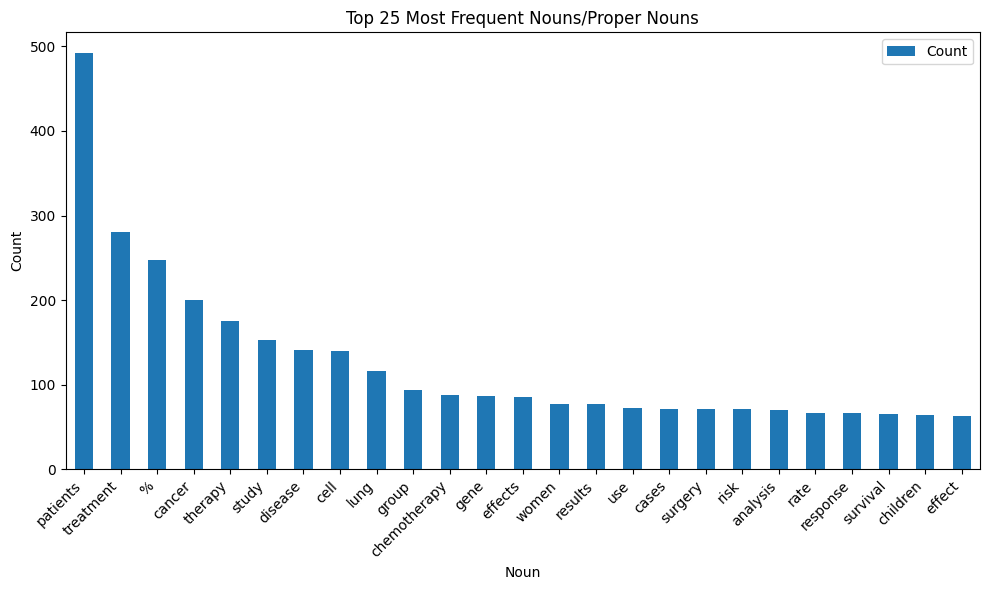

In [ ]:
noun_df.head(25).plot(x='Noun', y='Count', kind='bar', figsize=(10, 6))
plt.title('Top 25 Most Frequent Nouns/Proper Nouns')
plt.xlabel('Noun')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

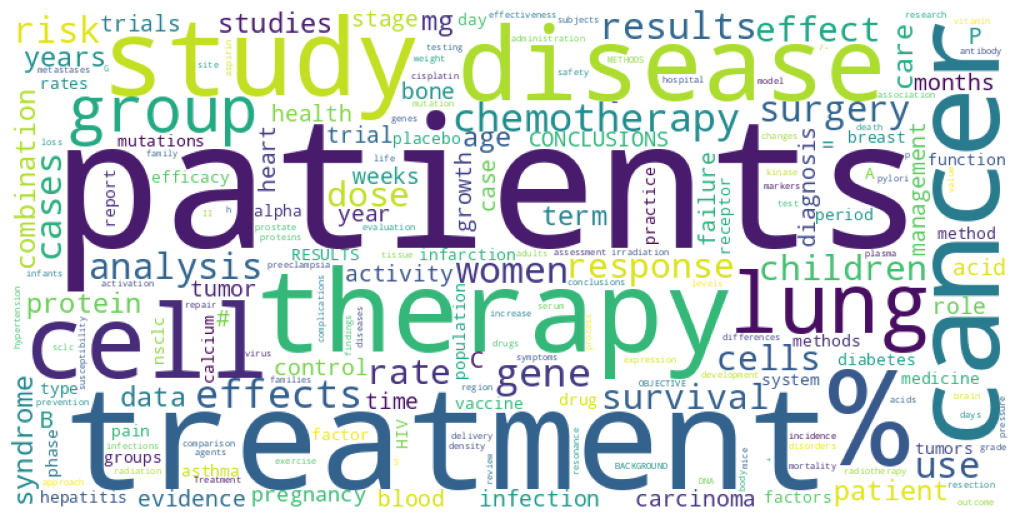

In [ ]:
# Create a word cloud from the 'noun_df'
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(noun_dict)

# Display the generated image:
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


## Defining features for CRF





In [ ]:
def word2features(sent, i, pos, dep):
    """
    Extracts a rich set of features for a word at index `i` in a sentence for use in NLP models,
    such as Named Entity Recognition (NER) or Part-of-Speech (POS) tagging.

    Args:
        sent (list): The sentence as a list of word strings.
        i (int): The index of the target word in the sentence.
        pos (list): The list of POS tags corresponding to the sentence.
        dep (list): The list of dependency labels corresponding to the sentence.

    Returns:
        list: A list of string-based features for the word at index `i`,
              including information about the word itself, its neighbors,
              POS tags, dependency tags, and various lexical properties.
    """
    word = sent[i]
    sent_length = len(sent)

    # Features from the word
    features = [
        'word.lower()=' + word.lower(),                    # Lowercase form
        'word.pos_=' + pos[i],                             # POS tag ##
        'word.dep_=' + dep[i],                             # Dependency label
        'word_SoS=%s' % str(i == 0),                       # Start of sentence ##
        'word_EoS=%s' % str(i == sent_length - 1),         # End of sentence ##
        'word[-3:]=' + word[-3:],                          # Last 3 characters
        'word[-2:]=' + word[-2:],                          # Last 2 characters
        'word.startsWithCapital=%s' % word[0].isupper(),   # Starts with capital letter
        'word.isupper()=%s' % word.isupper(),              # All uppercase
        'word.islower()=%s' % word.islower(),              # All lowercase
        'word.isdigit()=%s' % word.isdigit(),              # Is a digit
        'word.isalpha()=%s' % word.isalpha(),              # Is alphabetic
        'word.endswith("ing")=%s' % word.endswith("ing"),  # Ends with 'ing'
        'word.endswith("apy")=%s' % word.endswith("apy"),  # Ends with 'apy'
        'word.endswith("tion")=%s' % word.endswith("tion") # Ends with 'tion'
    ]

    # Features from the previous word (if it exists)
    if i - 1 >= 0:
        prev_word = sent[i - 1]
        features.extend([
            'prev_word.lower()=' + prev_word.lower(),
            'prev_word.pos_=' + pos[i-1],                  # POS tag ##
            'prev_word.dep_=' + dep[i-1],
            'prev_word[-3:]=' + prev_word[-3:],
            'prev_word[-2:]=' + prev_word[-2:],
            'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
            'prev_word.isupper()=%s' % prev_word.isupper(),
            'prev_word.islower()=%s' % prev_word.islower(),
            'prev_word.isdigit()=%s' % prev_word.isdigit(),
            'prev_word.isalpha()=%s' % prev_word.isalpha(),
            'prev_word.endswith("ing")=%s' % prev_word.endswith("ing"),
            'prev_word.endswith("apy")=%s' % prev_word.endswith("apy"),
            'prev_word.endswith("tion")=%s' % prev_word.endswith("tion"),
        ])

    # Features from the next word (if it exists)
    if i + 1 <= sent_length - 1:
        next_word = sent[i + 1]
        features.extend([
            'next_word.lower()=' + next_word.lower(),
            'next_word.pos_=' + pos[i+1],                  # POS tag ##
            'next_word.dep_=' + dep[i+1],
            'next_word[-3:]=' + next_word[-3:],
            'next_word[-2:]=' + next_word[-2:],
            'next_word.startsWithCapital=%s' % next_word[0].isupper(),
            'next_word.isupper()=%s' % next_word.isupper(),
            'next_word.islower()=%s' % next_word.islower(),
            'next_word.isdigit()=%s' % next_word.isdigit(),
            'next_word.isalpha()=%s' % next_word.isalpha(),
            'next_word.endswith("ing")=%s' % next_word.endswith("ing"),
            'next_word.endswith("apy")=%s' % next_word.endswith("apy"),
            'next_word.endswith("tion")=%s' % next_word.endswith("tion"),
        ])

    return features

To make spaCy tokenize like str.split(), we will use a custom tokenizer in the spaCy pipeline.

In [ ]:
# Load the small English model from spaCy
nlp_c = spacy.load("en_core_web_sm")

# Disable Named Entity Recognition (NER) to speed up processing
nlp_c.disable_pipes("ner")

# To make spaCy tokenize like str.split(), we will use a custom tokenizer.
# Override tokenizer with a simple whitespace tokenizer
nlp_c.tokenizer = Tokenizer(nlp_c.vocab, rules={}, prefix_search=None, suffix_search=None,
                     infix_finditer=None, token_match=None)

In [ ]:
def sent2features(sent):
    """
    Converts a sentence into a list of feature sets, one for each word in the sentence.
    Uses custom simple whitespace tokenizer
    Utilizes the `word2features` function to extract features based on the word,
    its part-of-speech (POS) tag, and dependency label.

    Args:
        sent (str): The input sentence as a string.

    Returns:
        list: A list of feature lists, one per token in the sentence, where each
              feature list corresponds to the features generated by `word2features`.
    """
    # Process the sentence using a spaCy pipeline
    doc = nlp_c(sent)

    # Extract tokens, POS tags, and dependency labels from the spaCy Doc object
    tokens = [token.text for token in doc]
    pos = [token.pos_ for token in doc]
    dep = [token.dep_ for token in doc]

    # Generate features for each token using the word2features function
    return [word2features(tokens, i, pos, dep) for i in range(len(tokens))]

## Getting the features

### Write a code/function to get the features for a sentence

In [ ]:
print('Example sentence ==>')
train_sent[:1]

Example sentence ==>


['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )']

In [ ]:
print("Features for sentence ==>")
print([sent2features(s) for s in train_sent[:1]])

Features for sentence ==>
[[['word.lower()=all', 'word.pos_=DET', 'word.dep_=det', 'word_SoS=True', 'word_EoS=False', 'word[-3:]=All', 'word[-2:]=ll', 'word.startsWithCapital=True', 'word.isupper()=False', 'word.islower()=False', 'word.isdigit()=False', 'word.isalpha()=True', 'word.endswith("ing")=False', 'word.endswith("apy")=False', 'word.endswith("tion")=False', 'next_word.lower()=live', 'next_word.pos_=ADJ', 'next_word.dep_=amod', 'next_word[-3:]=ive', 'next_word[-2:]=ve', 'next_word.startsWithCapital=False', 'next_word.isupper()=False', 'next_word.islower()=True', 'next_word.isdigit()=False', 'next_word.isalpha()=True', 'next_word.endswith("ing")=False', 'next_word.endswith("apy")=False', 'next_word.endswith("tion")=False'], ['word.lower()=live', 'word.pos_=ADJ', 'word.dep_=amod', 'word_SoS=False', 'word_EoS=False', 'word[-3:]=ive', 'word[-2:]=ve', 'word.startsWithCapital=False', 'word.isupper()=False', 'word.islower()=True', 'word.isdigit()=False', 'word.isalpha()=True', 'word.en

In [ ]:
print("Features for sentence - split by word ==>")
for word, features in zip(train_sent[:1][0].split(), [sent2features(s) for s in train_sent[:1]][0]):
    print("WORD=", word, "|", "FEATURES=", features)

Features for sentence - split by word ==>
WORD= All | FEATURES= ['word.lower()=all', 'word.pos_=DET', 'word.dep_=det', 'word_SoS=True', 'word_EoS=False', 'word[-3:]=All', 'word[-2:]=ll', 'word.startsWithCapital=True', 'word.isupper()=False', 'word.islower()=False', 'word.isdigit()=False', 'word.isalpha()=True', 'word.endswith("ing")=False', 'word.endswith("apy")=False', 'word.endswith("tion")=False', 'next_word.lower()=live', 'next_word.pos_=ADJ', 'next_word.dep_=amod', 'next_word[-3:]=ive', 'next_word[-2:]=ve', 'next_word.startsWithCapital=False', 'next_word.isupper()=False', 'next_word.islower()=True', 'next_word.isdigit()=False', 'next_word.isalpha()=True', 'next_word.endswith("ing")=False', 'next_word.endswith("apy")=False', 'next_word.endswith("tion")=False']
WORD= live | FEATURES= ['word.lower()=live', 'word.pos_=ADJ', 'word.dep_=amod', 'word_SoS=False', 'word_EoS=False', 'word[-3:]=ive', 'word[-2:]=ve', 'word.startsWithCapital=False', 'word.isupper()=False', 'word.islower()=True

### Write a code/function to get the labels of a sentence

In [ ]:
def sent2labels(sent):
    """
    Splits a label sentence string into a list of individual labels.

    Parameters:
    sent (str): A string containing space-separated labels corresponding to each token in a sentence.

    Returns:
    list: A list of labels as strings.
    """
    return [label for label in sent.split()]

In [ ]:
print([sent2labels(s) for s in train_label[:1]])

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [ ]:
X_train = [sent2features(s) for s in train_sent]
X_test = [sent2features(s) for s in test_sent]

### Define the labels as the target variable for test and the train dataset

In [ ]:
y_train = [sent2labels(s) for s in train_label]
y_test = [sent2labels(s) for s in test_label]

### Verify created datasets

In [ ]:
print("Check if number of train sentences matches X_train:", len(train_sent) == len(X_train))
print("Check if number of train labels matches y_train:", len(train_label) == len(y_train))
print("Check if number of test sentences matches X_test:", len(test_sent) == len(X_test))
print("Check if number of test labels matches y_test:", len(test_sent) == len(y_test))

Check if number of train sentences matches X_train: True
Check if number of train labels matches y_train: True
Check if number of test sentences matches X_test: True
Check if number of test labels matches y_test: True


In [ ]:
def verify_alignment(sents, labels, features_list, ylabels_list, set_name="Dataset"):
    """
    Verifies the alignment between tokens, labels, extracted features, and output labels for a given dataset.

    Parameters:
    sents (list): List of raw sentence strings.
    labels (list): List of label strings (space-separated) corresponding to tokens in each sentence.
    features_list (list): List of feature lists extracted for each token in the sentences.
    ylabels_list (list): List of label lists for model training/evaluation corresponding to tokens.
    set_name (str): Name of the dataset (e.g., "Train Set", "Test Set") for printing context.

    Prints:
    - Mismatched sentence details if any.
    - Summary of total matched and mismatched sentence alignments.
    """

    print(f"\nVerifying token-label-feature alignment for {set_name}")

    total = len(sents)         # Total number of sentences
    matched = 0                # Counter for correctly aligned sentences
    mismatched = 0             # Counter for misaligned sentences

    for sent, label, features, ylabels in zip(sents, labels, features_list, ylabels_list):
        # Count tokens and associated labels/features
        token_count = len(sent.split())
        label_count = len(label.split())
        feature_count = len(features)
        ylabel_count = len(ylabels)

        # Check if all counts match
        if token_count == label_count == feature_count == ylabel_count:
            matched += 1
        else:
            mismatched += 1
            print("\n--- Mismatch found ---")
            print("Sentence:", sent)
            print("Token count:", token_count)
            print("Label count:", label_count)
            print("Feature count:", feature_count)
            print("YLabel count:", ylabel_count)

    # Print final summary
    print(f"  {set_name} - Total sentences checked: {total}")
    print(f"  {set_name} - Matched: {matched}")
    print(f"  {set_name} - Mismatched: {mismatched}")

In [ ]:
verify_alignment(train_sent, train_label, X_train, y_train, set_name="Train Set")
verify_alignment(test_sent, test_label, X_test, y_test, set_name="Test Set")


Verifying token-label-feature alignment for Train Set
  Train Set - Total sentences checked: 2599
  Train Set - Matched: 2599
  Train Set - Mismatched: 0

Verifying token-label-feature alignment for Test Set
  Test Set - Total sentences checked: 1056
  Test Set - Matched: 1056
  Test Set - Mismatched: 0


## Define input and target variables


## Build the CRF Model

In [ ]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=500)

In [ ]:
crf.fit(X_train, y_train)

CRF(max_iterations=500)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [ ]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [ ]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.919220787065141

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

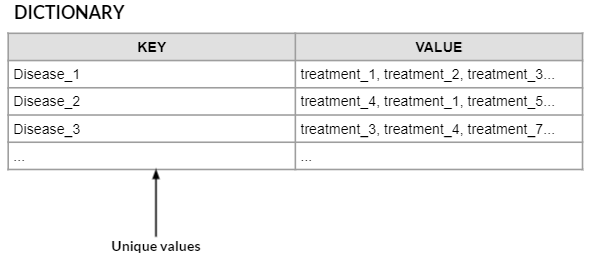

In [ ]:
def create_Diseases_vs_Treatment_Dict(sents, labels):
    """
    Creates a dictionary mapping disease entities to corresponding treatment entities
    based on labeled NER tags in sentences.

    Parameters:
    sents (list): List of sentence strings.
    labels (list): List of NER tag sequences (as lists or strings), where each tag corresponds
                   to the respective word in the sentence.
                   'D' denotes a Disease entity, 'T' denotes a Treatment entity.

    Returns:
    dict: A dictionary where keys are disease names and values are associated treatments
          (as comma-separated strings if multiple treatments are found).
    """

    Diseases_vs_Treatment_Dict = dict()

    # Iterate over sentence and corresponding label list
    for sentence, ner_tags in zip(sents, labels):

        # Initialize empty string to build disease entity
        disease = str()
        # Extract disease entity from words tagged as 'D'
        for word, ner_tag in zip(sentence.lower().split(), ner_tags):
            if ner_tag == 'D':
                if disease == '':
                    disease = word
                else:
                    disease = disease.strip() + ' ' + word

        # Initialize empty string to build treatment entity
        treatment = str()
        # Extract treatment entity from words tagged as 'T'
        for word, ner_tag in zip(sentence.lower().split(), ner_tags):
            if ner_tag == 'T':
                if treatment == '':
                    treatment = word
                else:
                    treatment = treatment.strip() + ' ' + word

        # If a disease was found, add it to the dictionary
        if disease != '' and treatment != '':
            # If disease already exists in the dictionary, append new treatment
            if disease in Diseases_vs_Treatment_Dict:
                Diseases_vs_Treatment_Dict[disease] = Diseases_vs_Treatment_Dict[disease] + ', ' + treatment
            else:
                Diseases_vs_Treatment_Dict[disease] = treatment

    return Diseases_vs_Treatment_Dict

In [ ]:
Diseases_vs_Treatment_Dict = create_Diseases_vs_Treatment_Dict(test_sent, y_pred)

In [ ]:
# convert dictionary into a pandas dataframe and print
df = pd.DataFrame(list(Diseases_vs_Treatment_Dict.items()), columns=['Disease', 'Treatment'])
df

,Disease,Treatment
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina or non-q-wave myocardial infar...,roxithromycin
3,foot infection,g-csf treatment
4,early parkinson 's disease,ropinirole monotherapy
...,...,...
123,temporomandibular joint arthropathy,arthroscopic treatment
124,severe secondary peritonitis,surgical management
125,hepatic metastases from colorectal cancer,hepatic arterial infusion of chemotherapy
126,glaucoma,brimonidine tartrate


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [ ]:
print(f'Treatment for hereditary retinoblastoma is {Diseases_vs_Treatment_Dict.get("hereditary retinoblastoma")}')

Treatment for hereditary retinoblastoma is radiotherapy
